# Metric computation - IoU intersection over union

main objective: compare two GeoJson files of polygons.

## Basics

(a) True Positive: The area of intersection between Ground Truth(GT) and segmentation mask(S). Mathematically, this is logical AND operation of GT and S i.e., 
$$TP = GT.S$$

(b) False Positive: The predicted area outside the Ground Truth. This is the logical OR of GT and segmentation minus GT. 
$$FP=(GT+S) - GT$$

(c) False Negative: Number of pixels in the Ground Truth area that the model failed to predict. This is the logical OR of GT and segmentation minus S.
$$FN=(GT+S) -S$$

$$IoU = \frac{TP}{TP+FP+FN}$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely

import utils.parse_geojson as pg
from models.model_polygonise import SegmentBasedClustering, predict_poly
from utils.metrics import average_iou
from utils.plots import try_to_polygonize

## Step 0: data check

In [3]:
# Open the predition and ground truth files
# data_folder = Path("data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres/")
data_folder = Path("data/spaces-walls/CH Lens/CH Lens B0")
x_file = "Walls.geojson"
pred_file = Path()
ground_truth_file = Path("Spaces.geojson")

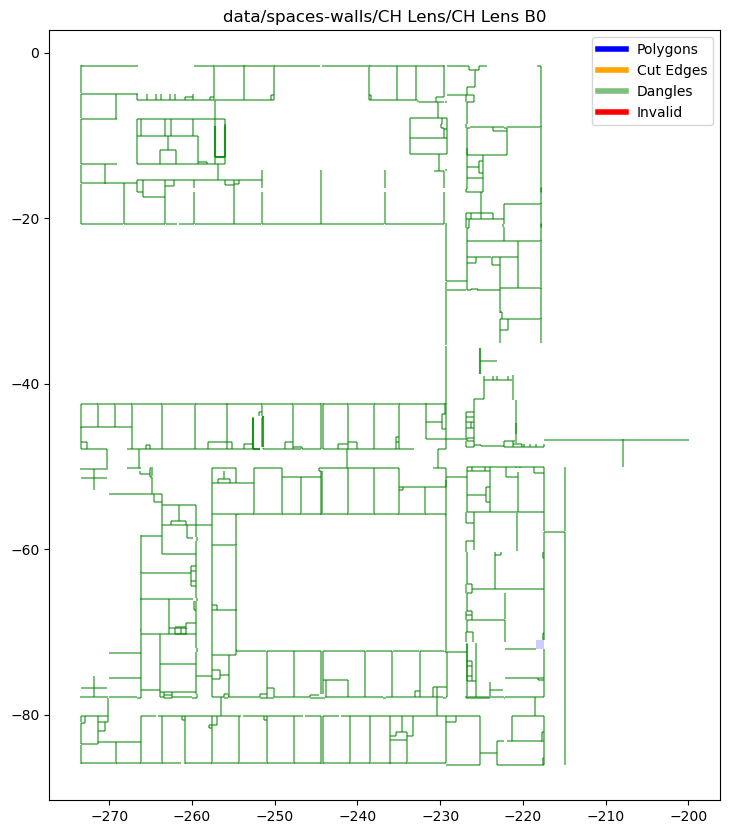

1 polygons detected


In [4]:
try_to_polygonize(data_folder / x_file, outsize=10)

### Baseline

In [9]:
x = pg.load_geometrycollection_from_geojson(data_folder / x_file)
predict_poly()

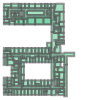

In [11]:
geoms_true = pg.load_geometrycollection_from_geojson(
    data_folder / ground_truth_file
)
geoms_true

In [13]:
average_iou(geoms_true.geoms, predict_poly().geoms)

AttributeError: 'predict_poly' object has no attribute 'geoms'

### Vectorize algo

In [8]:
segments = pg.extract_segments(x)
sgc = SegmentBasedClustering(segments)
y_pred = shapely.GeometryCollection(sgc.fit())

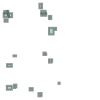

In [9]:
y_pred

In [10]:
average_iou(geoms_true.geoms, y_pred.geoms)

np.float64(0.004690097939347594)

# Base check on all files

In [16]:
# Iterate through all subfolders of data folder
# At each leaf folder:
# - x = pg.load_GeometryCollection_from_geojson(data_folder / x_file)
# - Pefrom the 2 predictions with base and clustering
# - Compute the average_iou
# - Display the result in a beatifull way fodlername / base IoU / SGC IoU

data_folder = Path("data/spaces-walls")
x_file = "Walls.geojson"
ground_truth_file = "Spaces.geojson"

for subfolder in data_folder.glob("**/"):
    if (
        subfolder.is_dir()
        and (subfolder / x_file).exists()
        and (subfolder / ground_truth_file).exists()
    ):
        start_time = time.time()
        x = pg.load_GeometryCollection_from_geojson(subfolder / x_file)
        geoms_true = pg.load_GeometryCollection_from_geojson(
            subfolder / ground_truth_file,
        )
        # Perform the 2 predictions
        y_pred1 = predict_poly(x)
        segments = pg.extract_segments(x)
        sgc = SegmentBasedClustering(segments)
        y_pred2 = shapely.GeometryCollection(sgc.fit())

        # Compute the average_iou
        iou1 = average_iou(geoms_true.geoms, y_pred1.geoms)
        iou2 = average_iou(geoms_true.geoms, y_pred2.geoms)

        # Display the result
        print(
            f"Base IoU: {iou1:.3f}\t SGC IoU: {iou2:.3f}\t"
            f"({time.time() - start_time:.2f}s)\tfor {subfolder}",
        )

Base IoU: nan	 SGC IoU: 0.033	(0.03s)	for data/spaces-walls/Campus ParisTech/N0
Base IoU: nan	 SGC IoU: 0.034	(0.02s)	for data/spaces-walls/Campus ParisTech/N1
Base IoU: nan	 SGC IoU: 0.034	(0.03s)	for data/spaces-walls/Campus ParisTech/SS1
Base IoU: 0.033	 SGC IoU: 0.029	(0.02s)	for data/spaces-walls/Campus ParisTech/N3
Base IoU: 0.045	 SGC IoU: 0.036	(0.02s)	for data/spaces-walls/Campus ParisTech/N2
Base IoU: nan	 SGC IoU: 0.008	(0.04s)	for data/spaces-walls/CH Lens/CH Lens Niv 3
Base IoU: nan	 SGC IoU: 0.008	(0.07s)	for data/spaces-walls/CH Lens/CH Lens Niv 2
Base IoU: 0.001	 SGC IoU: 0.003	(0.40s)	for data/spaces-walls/CH Lens/CH Lens B1
Base IoU: nan	 SGC IoU: 0.027	(0.01s)	for data/spaces-walls/CH Lens/CH Lens Niv 1 Treso
Base IoU: 0.000	 SGC IoU: 0.002	(0.51s)	for data/spaces-walls/CH Lens/CH Lens D3
Base IoU: 0.000	 SGC IoU: 0.005	(0.16s)	for data/spaces-walls/CH Lens/CH Lens B0
Base IoU: 0.000	 SGC IoU: 0.002	(0.50s)	for data/spaces-walls/CH Lens/CH Lens D2
Base IoU: nan	 SGC 

8 polygons found


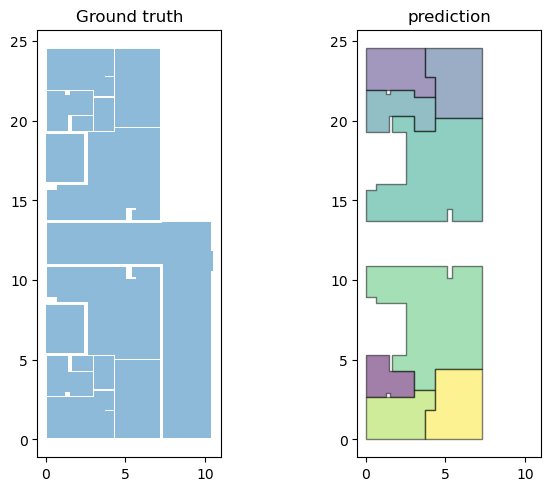

In [46]:
# Display the best IoU
best_subfolder = Path(
    "Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres"
)

fig, axs = plt.subplots(1, 2, layout="constrained")
# Ground Truth
axs[0].set_title("Ground truth")
geoms_true = pg.load_GeometryCollection_from_geojson(
    data_folder / best_subfolder / ground_truth_file,
)
gpd.GeoSeries(geoms_true).plot(ax=axs[0], alpha=0.5)

# Predictions
x = pg.load_GeometryCollection_from_geojson(
    data_folder / best_subfolder / x_file
)
segments = pg.extract_segments(x)
sgc = SegmentBasedClustering(segments)
y_pred = sgc.fit()
print(f"{len(y_pred)} polygons found")
y_pred_df = gpd.GeoDataFrame(
    y_pred,
    columns=["geometry"],
).reset_index()
y_pred_df.plot(ax=axs[1], alpha=0.5, column="index", edgecolor="black")
axs[1].set_title("prediction")
axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_xlim()

plt.show()
